In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers 
import scipy.stats as stats
import os 
import h5py
import sys
import re
%matplotlib inline 

In [2]:
model_name = "subtract_lepphi_0_2pi"

In [3]:
# Throw away lepton mass 
# os.chdir('./../../../../../data/hongtao')
be = h5py.File('./../../../../../data/hongtao/variables_tt_re.h5','r')
bmu = h5py.File('./../../../../../data/hongtao/variables_tt_rmu.h5','r')
be1 = h5py.File('./../../../../../data/hongtao/variables_tt_re1.h5','r')
print(be.keys())
print('')
print(be1.keys())
dataset = be1

<KeysViewHDF5 ['j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt', 'j8_eta', 'j8_isbtag', 'j8_m', 'j8_phi', 'j8_pt', 'lep_eta', 'lep_m', 'lep_phi', 'lep_pt', 'met_met', 'met_phi', 'mttReco', 'mttTrue']>

<KeysViewHDF5 ['bh_eta', 'bh_phi', 'bh_pt', 'bl_eta', 'bl_phi', 'bl_pt', 'j1_DL1r', 'j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_DL1r', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_DL1r', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_DL1r', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_DL1r', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_DL1r', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_DL1r', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt'

In [4]:
input_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
output_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_eta', 'wl_phi', 'wl_pt']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']

output_length = len(output_keys)
input_length = len(input_keys)
crop0 =  100000 

36


In [5]:
# plt.figure(figsize=(8,8*output_length))
# for i in range(0, output_length):
#     plt.subplot(output_length, 1, i+1)
#     plt.hist(dataset.get(output_keys[i]), 20, histtype='step')
#     plt.xlabel(output_keys[i])
#     plt.ylabel('Frequency')

In [6]:
lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]
def phi_transform(arr, max0, mean):
    arr = (arr-mean)
    arr = arr/max0/1.01/2+0.5
    z = stats.norm.ppf(arr)/2.5
    return z 

def invphi_transform(z, max0, mean):
    arr = stats.norm.cdf(2.5*z)
    arr = (arr-0.5)*max0*1.01*2+mean
    return arr 

def jet_existence_dict():
    dic = {}
    for key in phi_keys:
        variable = key.split('_')[0]
        if bool(re.match('^j[0-9]+$', variable)): # If the variable is a jet
            v = np.array(dataset.get(variable + '_pt'))[0:crop0]
            dic[key] = (v>1)*1
        else:
            dic[key] = np.ones(crop0, dtype=int)
    return dic
        
def phi1_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    x = w - 2*np.pi*(w>np.pi)
    y = x - (1-exist)*np.pi*1.1
    y = y-mean
    z = y/max0
    return z

def invphi1_transform(z, max0, mean, exist):
    y = z*max0+mean
    x = y+(1-exist)*np.pi*1.1
    w = x + 2*np.pi*(x<0)
    arr = (w + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 


def phi2_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    # x = w - 2*np.pi*(w>np.pi)
    y = w - (1-exist)*0.2
    z = y/(np.pi)
    return z

def invphi2_transform(z, max0, mean, exist):
    y = z*np.pi
    x = y+(1-exist)*0.2
    # w = x + 2*np.pi*(x<0)
    arr = (x + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 


def pt_transform(arr, max0, mean):
    return arr/max0

def invpt_transform(z, max0, mean):
    return z*max0 

def meanmax_transform(arr, max0, mean):
    arr = arr-mean
    z = arr/max0
    return z

def invmeanmax_transform(z, max0, mean):
    return z*max0+mean

def get_maxmean_dict(): 
    to_get = [pt_keys, eta_keys, m_keys, DL1r_keys]
    keys = ['pt', 'eta', 'm','DL1r']
    maxmean= {} 
    
    for i in range(4):
        dset = to_get[i]
        for x in dset:
            arr = []
            arr.append(np.array(dataset.get(x))[0:crop0])
        arr = np.stack(arr,axis=1)
        maxmean[keys[i]] = (np.max(np.abs(arr)), np.mean(arr))
    
    maxmean['phi'] = (np.pi, 0)
    maxmean['met'] = (np.max(np.abs(dataset.get('met_met'))), np.mean(dataset.get('met_met')))
    return maxmean 
    
def scale_arrays(keys, maxmean_dict):
    exist_dict = jet_existence_dict()
    lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]
    
    arrays = []
    for key in keys:
        var = np.array(dataset.get(key))[0:crop0]
        if key in phi_keys:
            max0, mean = maxmean_dict['phi']
            exist = exist_dict[key]
            if key == 'tl_phi' or key == 'wl_phi':
                z = phi1_transform(var, max0, mean, exist) 
            else:
                z = phi2_transform(var, max0, mean, exist)
        elif key in pt_keys:
            max0, mean = maxmean_dict['pt']
            z = pt_transform(var, max0, mean)
        elif key in m_keys:
            max0, mean = maxmean_dict['m']
            z = pt_transform(var, max0, mean)
        else:
            max0, mean = maxmean_dict[key.split('_')[1]]
            z = meanmax_transform(var, max0, mean)
        arrays.append(z)
    arrays = np.stack(arrays, axis=1)
    return arrays

def invscale_arrays(keys, arrays, maxmean_dict):
    exist_dict = jet_existence_dict()

    total = []
    for i in range(arrays.shape[1]):
        z=arrays[:,i]
        full_key = keys[i]
        key = keys[i].split('_')[1]
        if key == 'pt':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        elif key=='phi':
            max0, mean = maxmean_dict[key]
            exist = exist_dict[full_key]
            if full_key == 'tl_phi' or full_key == 'wl_phi':
                total.append(invphi1_transform(z, max0, mean, exist))
            else:
                total.append(invphi2_transform(z, max0, mean, exist))
        elif key=='m':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        else:
            max0, mean = maxmean_dict[key]
            total.append(invmeanmax_transform(z, max0, mean))
            
    return np.stack(total,axis=1) 

In [7]:
# Convert into numpy arrays and mean normalize

maxmean = get_maxmean_dict()
total_input = scale_arrays(input_keys, maxmean)

total_output = scale_arrays(output_keys, maxmean)
out_scaled = invscale_arrays(output_keys, total_output, maxmean)

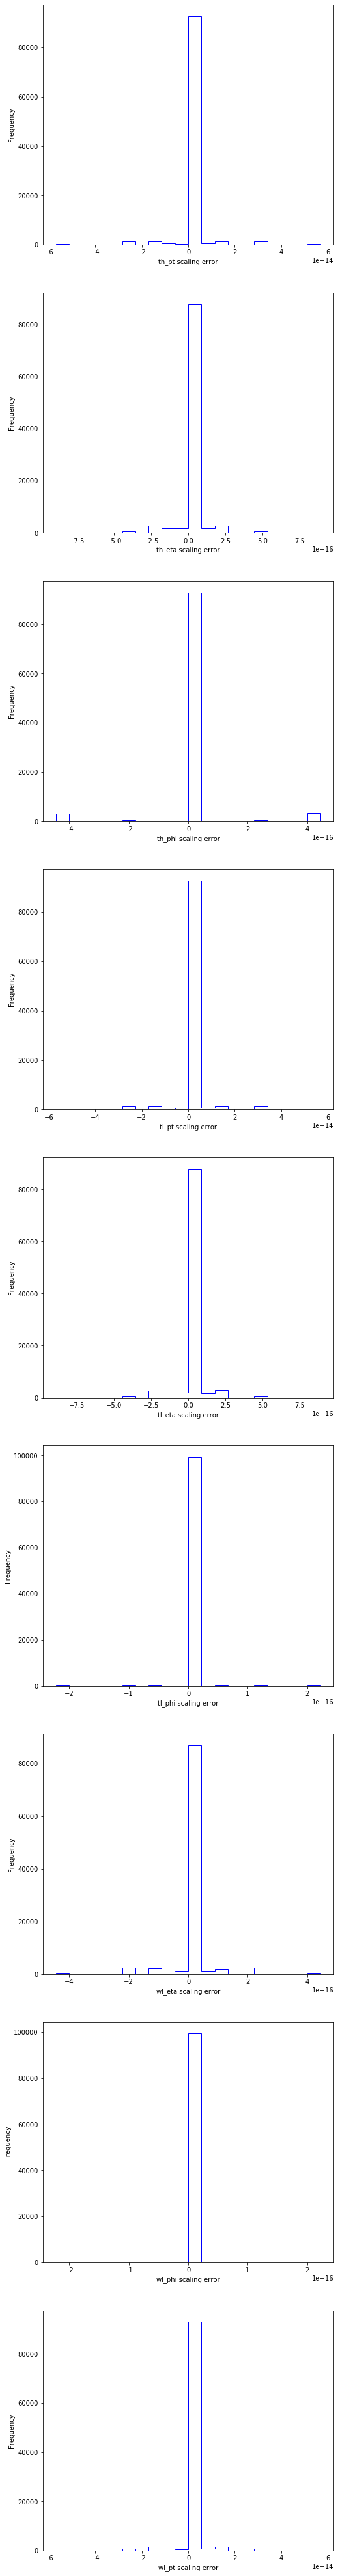

In [8]:
# Test inverse scaling

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    plt.hist(dataset.get(output_keys[i])[0:crop0] - out_scaled[:, i], 20, histtype='step', color='b')
    plt.xlabel(output_keys[i] + " scaling error")
    plt.ylabel('Frequency')

In [9]:
# Create input and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(total_input)
    np.random.set_state(rng_state)
    np.random.shuffle(total_output)

train_input, test_input = total_input[0:split, :], total_input[split:,:]
train_output, test_output = total_output[0:split,:], total_output[split:,:]

In [10]:
print(train_input.shape, train_output.shape)
print(test_input.shape, test_output.shape)

(80000, 36) (80000, 9)
(20000, 36) (20000, 9)


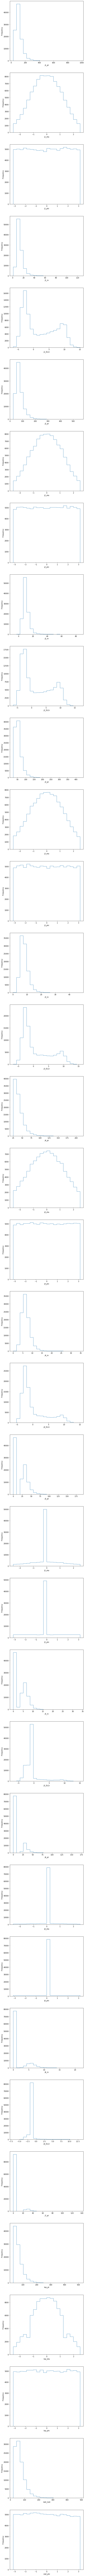

In [11]:
# Histograms of output variables 
show = True

if show:
    plt.figure(figsize=(8,8*output_length))
    for i in range(0, output_length):
        plt.subplot(output_length, 1, i+1)
        plt.hist(train_output[:,i], 20, histtype='step')
        plt.xlabel(output_keys[i])
        plt.ylabel('Frequency')

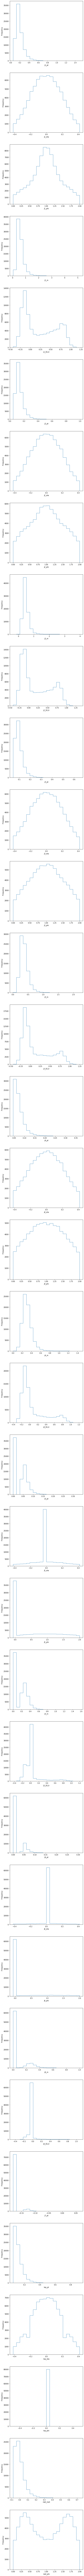

In [12]:
# Histograms of input variables 
show = True

if show:
    plt.figure(figsize=(8,8*input_length))
    for i in range(0, input_length):
        plt.subplot(input_length, 1, i+1)
        plt.hist(train_input[:,i], 20, histtype='step')
        plt.xlabel(input_keys[i])
        plt.ylabel('Frequency')

 

In [13]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     input_shape=[len(input_keys)]),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(output_keys),  activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      input_shape=[len(input_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [14]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               18944     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1

In [15]:
# Fit model

Epochs= 4096

history = model.fit(train_input, train_output, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)


Epoch 1/4096
125/125 [==============================] - 1s 6ms/step - loss: 0.1970 - mse: 0.1902 - val_loss: 0.1939 - val_mse: 0.1871
Epoch 2/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.1926 - mse: 0.1859 - val_loss: 0.1896 - val_mse: 0.1829
Epoch 3/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.1883 - mse: 0.1816 - val_loss: 0.1852 - val_mse: 0.1784
Epoch 4/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.1837 - mse: 0.1769 - val_loss: 0.1802 - val_mse: 0.1735
Epoch 5/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.1784 - mse: 0.1717 - val_loss: 0.1747 - val_mse: 0.1680
Epoch 6/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.1726 - mse: 0.1659 - val_loss: 0.1687 - val_mse: 0.1620
Epoch 7/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.1664 - mse: 0.1597 - val_loss: 0.1621 - val_mse: 0.1554
Epoch 8/4096
125/125 [==============================] - 1s 5ms

Epoch 62/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0505 - mse: 0.0442 - val_loss: 0.0495 - val_mse: 0.0432
Epoch 63/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0502 - mse: 0.0440 - val_loss: 0.0492 - val_mse: 0.0430
Epoch 64/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0500 - mse: 0.0438 - val_loss: 0.0490 - val_mse: 0.0428
Epoch 65/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0498 - mse: 0.0435 - val_loss: 0.0488 - val_mse: 0.0426
Epoch 66/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0495 - mse: 0.0433 - val_loss: 0.0486 - val_mse: 0.0424
Epoch 67/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0493 - mse: 0.0431 - val_loss: 0.0484 - val_mse: 0.0422
Epoch 68/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0491 - mse: 0.0429 - val_loss: 0.0482 - val_mse: 0.0420
Epoch 69/4096
125/125 [==============================] 

125/125 [==============================] - 1s 5ms/step - loss: 0.0408 - mse: 0.0354 - val_loss: 0.0402 - val_mse: 0.0348
Epoch 183/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0407 - mse: 0.0353 - val_loss: 0.0402 - val_mse: 0.0348
Epoch 184/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0407 - mse: 0.0353 - val_loss: 0.0402 - val_mse: 0.0348
Epoch 185/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0407 - mse: 0.0353 - val_loss: 0.0402 - val_mse: 0.0348
Epoch 186/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0407 - mse: 0.0353 - val_loss: 0.0401 - val_mse: 0.0348
Epoch 187/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0406 - mse: 0.0353 - val_loss: 0.0401 - val_mse: 0.0347
Epoch 188/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0406 - mse: 0.0352 - val_loss: 0.0401 - val_mse: 0.0347
Epoch 189/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0384 - mse: 0.0337 - val_loss: 0.0381 - val_mse: 0.0333
Epoch 303/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0384 - mse: 0.0336 - val_loss: 0.0380 - val_mse: 0.0333
Epoch 304/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0384 - mse: 0.0336 - val_loss: 0.0380 - val_mse: 0.0332
Epoch 305/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0384 - mse: 0.0336 - val_loss: 0.0380 - val_mse: 0.0332
Epoch 306/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0384 - mse: 0.0336 - val_loss: 0.0380 - val_mse: 0.0332
Epoch 307/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0384 - mse: 0.0336 - val_loss: 0.0380 - val_mse: 0.0332
Epoch 308/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0384 - mse: 0.0336 - val_loss: 0.0380 - val_mse: 0.0332
Epoch 309/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0372 - mse: 0.0329 - val_loss: 0.0370 - val_mse: 0.0326
Epoch 423/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0372 - mse: 0.0329 - val_loss: 0.0370 - val_mse: 0.0326
Epoch 424/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0372 - mse: 0.0329 - val_loss: 0.0369 - val_mse: 0.0326
Epoch 425/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0372 - mse: 0.0329 - val_loss: 0.0369 - val_mse: 0.0326
Epoch 426/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0372 - mse: 0.0329 - val_loss: 0.0369 - val_mse: 0.0326
Epoch 427/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0372 - mse: 0.0329 - val_loss: 0.0369 - val_mse: 0.0326
Epoch 428/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0372 - mse: 0.0329 - val_loss: 0.0369 - val_mse: 0.0326
Epoch 429/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0364 - mse: 0.0324 - val_loss: 0.0362 - val_mse: 0.0322
Epoch 543/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0364 - mse: 0.0324 - val_loss: 0.0362 - val_mse: 0.0322
Epoch 544/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0364 - mse: 0.0324 - val_loss: 0.0362 - val_mse: 0.0322
Epoch 545/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0363 - mse: 0.0324 - val_loss: 0.0362 - val_mse: 0.0322
Epoch 546/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0363 - mse: 0.0324 - val_loss: 0.0362 - val_mse: 0.0322
Epoch 547/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0363 - mse: 0.0324 - val_loss: 0.0362 - val_mse: 0.0322
Epoch 548/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0363 - mse: 0.0324 - val_loss: 0.0362 - val_mse: 0.0322
Epoch 549/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0357 - mse: 0.0320 - val_loss: 0.0356 - val_mse: 0.0319
Epoch 663/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0357 - mse: 0.0320 - val_loss: 0.0356 - val_mse: 0.0319
Epoch 664/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0357 - mse: 0.0319 - val_loss: 0.0356 - val_mse: 0.0319
Epoch 665/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0357 - mse: 0.0319 - val_loss: 0.0356 - val_mse: 0.0319
Epoch 666/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0357 - mse: 0.0319 - val_loss: 0.0356 - val_mse: 0.0319
Epoch 667/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0357 - mse: 0.0319 - val_loss: 0.0356 - val_mse: 0.0319
Epoch 668/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0357 - mse: 0.0319 - val_loss: 0.0356 - val_mse: 0.0319
Epoch 669/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0351 - mse: 0.0316 - val_loss: 0.0352 - val_mse: 0.0316
Epoch 783/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0351 - mse: 0.0316 - val_loss: 0.0352 - val_mse: 0.0316
Epoch 784/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0351 - mse: 0.0316 - val_loss: 0.0352 - val_mse: 0.0316
Epoch 785/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0351 - mse: 0.0316 - val_loss: 0.0352 - val_mse: 0.0316
Epoch 786/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0351 - mse: 0.0316 - val_loss: 0.0351 - val_mse: 0.0316
Epoch 787/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0351 - mse: 0.0316 - val_loss: 0.0351 - val_mse: 0.0316
Epoch 788/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0351 - mse: 0.0316 - val_loss: 0.0351 - val_mse: 0.0316
Epoch 789/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0346 - mse: 0.0312 - val_loss: 0.0348 - val_mse: 0.0314
Epoch 903/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0346 - mse: 0.0312 - val_loss: 0.0348 - val_mse: 0.0314
Epoch 904/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0346 - mse: 0.0312 - val_loss: 0.0348 - val_mse: 0.0314
Epoch 905/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0346 - mse: 0.0312 - val_loss: 0.0348 - val_mse: 0.0314
Epoch 906/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0346 - mse: 0.0312 - val_loss: 0.0348 - val_mse: 0.0314
Epoch 907/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0346 - mse: 0.0312 - val_loss: 0.0348 - val_mse: 0.0314
Epoch 908/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0346 - mse: 0.0312 - val_loss: 0.0348 - val_mse: 0.0314
Epoch 909/4096
125/125 [==============================] - 1s 5m

Epoch 1022/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0342 - mse: 0.0310 - val_loss: 0.0345 - val_mse: 0.0312
Epoch 1023/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0342 - mse: 0.0310 - val_loss: 0.0345 - val_mse: 0.0312
Epoch 1024/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0342 - mse: 0.0310 - val_loss: 0.0345 - val_mse: 0.0312
Epoch 1025/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0342 - mse: 0.0309 - val_loss: 0.0345 - val_mse: 0.0312
Epoch 1026/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0342 - mse: 0.0309 - val_loss: 0.0345 - val_mse: 0.0312
Epoch 1027/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0342 - mse: 0.0309 - val_loss: 0.0345 - val_mse: 0.0312
Epoch 1028/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0342 - mse: 0.0309 - val_loss: 0.0344 - val_mse: 0.0312
Epoch 1029/4096
125/125 [================

Epoch 1082/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0340 - mse: 0.0308 - val_loss: 0.0343 - val_mse: 0.0312
Epoch 1083/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0340 - mse: 0.0308 - val_loss: 0.0343 - val_mse: 0.0312
Epoch 1084/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0340 - mse: 0.0308 - val_loss: 0.0343 - val_mse: 0.0312
Epoch 1085/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0340 - mse: 0.0308 - val_loss: 0.0343 - val_mse: 0.0312
Epoch 1086/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0340 - mse: 0.0308 - val_loss: 0.0343 - val_mse: 0.0311
Epoch 1087/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0340 - mse: 0.0308 - val_loss: 0.0343 - val_mse: 0.0311
Epoch 1088/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0340 - mse: 0.0308 - val_loss: 0.0343 - val_mse: 0.0311
Epoch 1089/4096
125/125 [================

Epoch 1142/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0338 - mse: 0.0307 - val_loss: 0.0342 - val_mse: 0.0311
Epoch 1143/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0338 - mse: 0.0307 - val_loss: 0.0342 - val_mse: 0.0311
Epoch 1144/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0338 - mse: 0.0307 - val_loss: 0.0342 - val_mse: 0.0311
Epoch 1145/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0338 - mse: 0.0307 - val_loss: 0.0342 - val_mse: 0.0311
Epoch 1146/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0338 - mse: 0.0307 - val_loss: 0.0342 - val_mse: 0.0311
Epoch 1147/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0338 - mse: 0.0307 - val_loss: 0.0342 - val_mse: 0.0311
Epoch 1148/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0338 - mse: 0.0307 - val_loss: 0.0342 - val_mse: 0.0311
Epoch 1149/4096
125/125 [================

Epoch 1202/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0336 - mse: 0.0306 - val_loss: 0.0341 - val_mse: 0.0310
Epoch 1203/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0336 - mse: 0.0306 - val_loss: 0.0341 - val_mse: 0.0310
Epoch 1204/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0336 - mse: 0.0306 - val_loss: 0.0341 - val_mse: 0.0310
Epoch 1205/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0336 - mse: 0.0306 - val_loss: 0.0341 - val_mse: 0.0310
Epoch 1206/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0336 - mse: 0.0306 - val_loss: 0.0341 - val_mse: 0.0310
Epoch 1207/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0336 - mse: 0.0306 - val_loss: 0.0341 - val_mse: 0.0310
Epoch 1208/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0336 - mse: 0.0306 - val_loss: 0.0341 - val_mse: 0.0310
Epoch 1209/4096
125/125 [================

Epoch 1262/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0335 - mse: 0.0305 - val_loss: 0.0340 - val_mse: 0.0310
Epoch 1263/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0335 - mse: 0.0305 - val_loss: 0.0340 - val_mse: 0.0310
Epoch 1264/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0335 - mse: 0.0304 - val_loss: 0.0340 - val_mse: 0.0310
Epoch 1265/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0335 - mse: 0.0304 - val_loss: 0.0340 - val_mse: 0.0310
Epoch 1266/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0335 - mse: 0.0304 - val_loss: 0.0340 - val_mse: 0.0310
Epoch 1267/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0335 - mse: 0.0304 - val_loss: 0.0340 - val_mse: 0.0310
Epoch 1268/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0335 - mse: 0.0304 - val_loss: 0.0340 - val_mse: 0.0310
Epoch 1269/4096
125/125 [================

Epoch 1322/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0333 - mse: 0.0303 - val_loss: 0.0339 - val_mse: 0.0309
Epoch 1323/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0333 - mse: 0.0303 - val_loss: 0.0339 - val_mse: 0.0309
Epoch 1324/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0333 - mse: 0.0303 - val_loss: 0.0339 - val_mse: 0.0309
Epoch 1325/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0333 - mse: 0.0303 - val_loss: 0.0339 - val_mse: 0.0309
Epoch 1326/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0333 - mse: 0.0303 - val_loss: 0.0339 - val_mse: 0.0309
Epoch 1327/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0333 - mse: 0.0303 - val_loss: 0.0339 - val_mse: 0.0309
Epoch 1328/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0333 - mse: 0.0303 - val_loss: 0.0339 - val_mse: 0.0309
Epoch 1329/4096
125/125 [================

Epoch 1382/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0331 - mse: 0.0302 - val_loss: 0.0338 - val_mse: 0.0309
Epoch 1383/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0331 - mse: 0.0302 - val_loss: 0.0338 - val_mse: 0.0309
Epoch 1384/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0331 - mse: 0.0302 - val_loss: 0.0338 - val_mse: 0.0309
Epoch 1385/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0331 - mse: 0.0302 - val_loss: 0.0338 - val_mse: 0.0309
Epoch 1386/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0331 - mse: 0.0302 - val_loss: 0.0338 - val_mse: 0.0309
Epoch 1387/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0331 - mse: 0.0302 - val_loss: 0.0338 - val_mse: 0.0309
Epoch 1388/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0331 - mse: 0.0302 - val_loss: 0.0338 - val_mse: 0.0309
Epoch 1389/4096
125/125 [================

Epoch 1442/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0330 - mse: 0.0301 - val_loss: 0.0337 - val_mse: 0.0308
Epoch 1443/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0330 - mse: 0.0301 - val_loss: 0.0337 - val_mse: 0.0308
Epoch 1444/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0330 - mse: 0.0301 - val_loss: 0.0337 - val_mse: 0.0308
Epoch 1445/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0330 - mse: 0.0301 - val_loss: 0.0337 - val_mse: 0.0308
Epoch 1446/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0330 - mse: 0.0301 - val_loss: 0.0337 - val_mse: 0.0308
Epoch 1447/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0330 - mse: 0.0301 - val_loss: 0.0337 - val_mse: 0.0308
Epoch 1448/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0330 - mse: 0.0301 - val_loss: 0.0337 - val_mse: 0.0308
Epoch 1449/4096
125/125 [================

Epoch 1502/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0328 - mse: 0.0300 - val_loss: 0.0336 - val_mse: 0.0308
Epoch 1503/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0328 - mse: 0.0300 - val_loss: 0.0336 - val_mse: 0.0308
Epoch 1504/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0328 - mse: 0.0300 - val_loss: 0.0336 - val_mse: 0.0308
Epoch 1505/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0328 - mse: 0.0300 - val_loss: 0.0336 - val_mse: 0.0308
Epoch 1506/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0328 - mse: 0.0300 - val_loss: 0.0336 - val_mse: 0.0308
Epoch 1507/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0328 - mse: 0.0300 - val_loss: 0.0336 - val_mse: 0.0308
Epoch 1508/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0328 - mse: 0.0300 - val_loss: 0.0336 - val_mse: 0.0308
Epoch 1509/4096
125/125 [================

Epoch 1562/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0327 - mse: 0.0299 - val_loss: 0.0336 - val_mse: 0.0307
Epoch 1563/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0327 - mse: 0.0299 - val_loss: 0.0336 - val_mse: 0.0307
Epoch 1564/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0327 - mse: 0.0299 - val_loss: 0.0336 - val_mse: 0.0307
Epoch 1565/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0327 - mse: 0.0299 - val_loss: 0.0336 - val_mse: 0.0307
Epoch 1566/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0327 - mse: 0.0299 - val_loss: 0.0336 - val_mse: 0.0307
Epoch 1567/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0327 - mse: 0.0299 - val_loss: 0.0335 - val_mse: 0.0307
Epoch 1568/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0327 - mse: 0.0299 - val_loss: 0.0335 - val_mse: 0.0307
Epoch 1569/4096
125/125 [================

Epoch 1622/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0325 - mse: 0.0298 - val_loss: 0.0335 - val_mse: 0.0307
Epoch 1623/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0325 - mse: 0.0297 - val_loss: 0.0335 - val_mse: 0.0307
Epoch 1624/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0325 - mse: 0.0297 - val_loss: 0.0335 - val_mse: 0.0307
Epoch 1625/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0325 - mse: 0.0297 - val_loss: 0.0335 - val_mse: 0.0307
Epoch 1626/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0325 - mse: 0.0297 - val_loss: 0.0335 - val_mse: 0.0307
Epoch 1627/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0325 - mse: 0.0297 - val_loss: 0.0335 - val_mse: 0.0307
Epoch 1628/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0325 - mse: 0.0297 - val_loss: 0.0335 - val_mse: 0.0307
Epoch 1629/4096
125/125 [================

Epoch 1682/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0324 - mse: 0.0296 - val_loss: 0.0334 - val_mse: 0.0307
Epoch 1683/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0324 - mse: 0.0296 - val_loss: 0.0334 - val_mse: 0.0307
Epoch 1684/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0324 - mse: 0.0296 - val_loss: 0.0334 - val_mse: 0.0307
Epoch 1685/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0324 - mse: 0.0296 - val_loss: 0.0334 - val_mse: 0.0307
Epoch 1686/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0324 - mse: 0.0296 - val_loss: 0.0334 - val_mse: 0.0307
Epoch 1687/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0324 - mse: 0.0296 - val_loss: 0.0334 - val_mse: 0.0307
Epoch 1688/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0324 - mse: 0.0296 - val_loss: 0.0334 - val_mse: 0.0307
Epoch 1689/4096
125/125 [================

Epoch 1742/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0322 - mse: 0.0295 - val_loss: 0.0334 - val_mse: 0.0306
Epoch 1743/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0322 - mse: 0.0295 - val_loss: 0.0334 - val_mse: 0.0306
Epoch 1744/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0322 - mse: 0.0295 - val_loss: 0.0334 - val_mse: 0.0306
Epoch 1745/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0322 - mse: 0.0295 - val_loss: 0.0334 - val_mse: 0.0306
Epoch 1746/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0322 - mse: 0.0295 - val_loss: 0.0334 - val_mse: 0.0306
Epoch 1747/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0322 - mse: 0.0295 - val_loss: 0.0334 - val_mse: 0.0306
Epoch 1748/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0322 - mse: 0.0295 - val_loss: 0.0334 - val_mse: 0.0306
Epoch 1749/4096
125/125 [================

Epoch 1802/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0321 - mse: 0.0294 - val_loss: 0.0333 - val_mse: 0.0306
Epoch 1803/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0321 - mse: 0.0294 - val_loss: 0.0333 - val_mse: 0.0306
Epoch 1804/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0321 - mse: 0.0294 - val_loss: 0.0333 - val_mse: 0.0306
Epoch 1805/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0321 - mse: 0.0294 - val_loss: 0.0333 - val_mse: 0.0306
Epoch 1806/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0321 - mse: 0.0294 - val_loss: 0.0333 - val_mse: 0.0306
Epoch 1807/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0321 - mse: 0.0294 - val_loss: 0.0333 - val_mse: 0.0306
Epoch 1808/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0321 - mse: 0.0294 - val_loss: 0.0333 - val_mse: 0.0306
Epoch 1809/4096
125/125 [================

Epoch 1862/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0320 - mse: 0.0293 - val_loss: 0.0333 - val_mse: 0.0306
Epoch 1863/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0320 - mse: 0.0293 - val_loss: 0.0333 - val_mse: 0.0306
Epoch 1864/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0320 - mse: 0.0293 - val_loss: 0.0333 - val_mse: 0.0306
Epoch 1865/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0320 - mse: 0.0293 - val_loss: 0.0333 - val_mse: 0.0306
Epoch 1866/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0320 - mse: 0.0293 - val_loss: 0.0333 - val_mse: 0.0306
Epoch 1867/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0320 - mse: 0.0293 - val_loss: 0.0333 - val_mse: 0.0306
Epoch 1868/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0320 - mse: 0.0293 - val_loss: 0.0333 - val_mse: 0.0306
Epoch 1869/4096
125/125 [================

Epoch 1922/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0318 - mse: 0.0292 - val_loss: 0.0332 - val_mse: 0.0306
Epoch 1923/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0318 - mse: 0.0292 - val_loss: 0.0332 - val_mse: 0.0306
Epoch 1924/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0318 - mse: 0.0292 - val_loss: 0.0332 - val_mse: 0.0306
Epoch 1925/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0318 - mse: 0.0292 - val_loss: 0.0332 - val_mse: 0.0306
Epoch 1926/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0318 - mse: 0.0292 - val_loss: 0.0332 - val_mse: 0.0306
Epoch 1927/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0318 - mse: 0.0292 - val_loss: 0.0332 - val_mse: 0.0306
Epoch 1928/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0318 - mse: 0.0292 - val_loss: 0.0332 - val_mse: 0.0306
Epoch 1929/4096
125/125 [================

Epoch 1982/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0317 - mse: 0.0291 - val_loss: 0.0332 - val_mse: 0.0305
Epoch 1983/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0317 - mse: 0.0291 - val_loss: 0.0332 - val_mse: 0.0305
Epoch 1984/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0317 - mse: 0.0291 - val_loss: 0.0332 - val_mse: 0.0305
Epoch 1985/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0317 - mse: 0.0291 - val_loss: 0.0332 - val_mse: 0.0305
Epoch 1986/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0317 - mse: 0.0291 - val_loss: 0.0332 - val_mse: 0.0305
Epoch 1987/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0317 - mse: 0.0291 - val_loss: 0.0332 - val_mse: 0.0305
Epoch 1988/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0317 - mse: 0.0291 - val_loss: 0.0332 - val_mse: 0.0305
Epoch 1989/4096
125/125 [================

Epoch 2042/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0316 - mse: 0.0290 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2043/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0316 - mse: 0.0290 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2044/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0316 - mse: 0.0290 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2045/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0316 - mse: 0.0290 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2046/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0316 - mse: 0.0290 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2047/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0316 - mse: 0.0290 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2048/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0316 - mse: 0.0290 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2049/4096
125/125 [================

Epoch 2102/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0315 - mse: 0.0289 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2103/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0314 - mse: 0.0289 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2104/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0314 - mse: 0.0289 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2105/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0314 - mse: 0.0289 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2106/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0314 - mse: 0.0289 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2107/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0314 - mse: 0.0289 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2108/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0314 - mse: 0.0289 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2109/4096
125/125 [================

Epoch 2162/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0313 - mse: 0.0288 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2163/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0313 - mse: 0.0288 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2164/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0313 - mse: 0.0288 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2165/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0313 - mse: 0.0288 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2166/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0313 - mse: 0.0288 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2167/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0313 - mse: 0.0288 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2168/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0313 - mse: 0.0287 - val_loss: 0.0331 - val_mse: 0.0305
Epoch 2169/4096
125/125 [================

Epoch 2222/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0312 - mse: 0.0287 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2223/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0312 - mse: 0.0287 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2224/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0312 - mse: 0.0287 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2225/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0312 - mse: 0.0287 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2226/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0312 - mse: 0.0287 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2227/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0312 - mse: 0.0286 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2228/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0312 - mse: 0.0286 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2229/4096
125/125 [================

Epoch 2282/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0311 - mse: 0.0286 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2283/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0311 - mse: 0.0286 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2284/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0311 - mse: 0.0286 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2285/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0311 - mse: 0.0285 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2286/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0311 - mse: 0.0285 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2287/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0311 - mse: 0.0285 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2288/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0311 - mse: 0.0285 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2289/4096
125/125 [================

Epoch 2401/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0309 - mse: 0.0284 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2402/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0309 - mse: 0.0284 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2403/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0309 - mse: 0.0283 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2404/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0308 - mse: 0.0283 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2405/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0308 - mse: 0.0283 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2406/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0308 - mse: 0.0283 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2407/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0308 - mse: 0.0283 - val_loss: 0.0330 - val_mse: 0.0305
Epoch 2408/4096
125/125 [================

Epoch 2461/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0307 - mse: 0.0283 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2462/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0307 - mse: 0.0282 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2463/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0307 - mse: 0.0282 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2464/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0307 - mse: 0.0282 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2465/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0307 - mse: 0.0282 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2466/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0307 - mse: 0.0282 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2467/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0307 - mse: 0.0282 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2468/4096
125/125 [================

Epoch 2521/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0306 - mse: 0.0282 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2522/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0306 - mse: 0.0281 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2523/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0306 - mse: 0.0281 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2524/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0306 - mse: 0.0281 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2525/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0306 - mse: 0.0281 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2526/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0306 - mse: 0.0281 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2527/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0306 - mse: 0.0281 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2528/4096
125/125 [================

Epoch 2581/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0305 - mse: 0.0281 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2582/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0305 - mse: 0.0280 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2583/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0305 - mse: 0.0280 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2584/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0305 - mse: 0.0280 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2585/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0305 - mse: 0.0280 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2586/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0305 - mse: 0.0280 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2587/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0305 - mse: 0.0280 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2588/4096
125/125 [================

Epoch 2641/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0304 - mse: 0.0280 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2642/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0304 - mse: 0.0280 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2643/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0304 - mse: 0.0280 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2644/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0304 - mse: 0.0279 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2645/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0304 - mse: 0.0279 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2646/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0304 - mse: 0.0279 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2647/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0304 - mse: 0.0279 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2648/4096
125/125 [================

Epoch 2701/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0303 - mse: 0.0279 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2702/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0303 - mse: 0.0279 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2703/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0303 - mse: 0.0279 - val_loss: 0.0329 - val_mse: 0.0304
Epoch 2704/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0303 - mse: 0.0279 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2705/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0303 - mse: 0.0279 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2706/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0303 - mse: 0.0278 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2707/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0303 - mse: 0.0278 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2708/4096
125/125 [================

Epoch 2761/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0302 - mse: 0.0278 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2762/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0302 - mse: 0.0278 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2763/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0302 - mse: 0.0278 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2764/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0302 - mse: 0.0278 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2765/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0302 - mse: 0.0278 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2766/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0302 - mse: 0.0278 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2767/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0302 - mse: 0.0278 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2768/4096
125/125 [================

Epoch 2821/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0301 - mse: 0.0277 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2822/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0301 - mse: 0.0277 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2823/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0301 - mse: 0.0277 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2824/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0301 - mse: 0.0277 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2825/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0301 - mse: 0.0277 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2826/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0301 - mse: 0.0277 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2827/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0301 - mse: 0.0277 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2828/4096
125/125 [================

Epoch 2881/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0300 - mse: 0.0276 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2882/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0300 - mse: 0.0276 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2883/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0300 - mse: 0.0276 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2884/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0300 - mse: 0.0276 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2885/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0300 - mse: 0.0276 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2886/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0300 - mse: 0.0276 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2887/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0300 - mse: 0.0276 - val_loss: 0.0329 - val_mse: 0.0305
Epoch 2888/4096
125/125 [================

In [16]:
history.history.keys()
model.save(model_name)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: subtract_lepphi_0_2pi/assets


Text(0.5, 1.0, 'MSE loss')

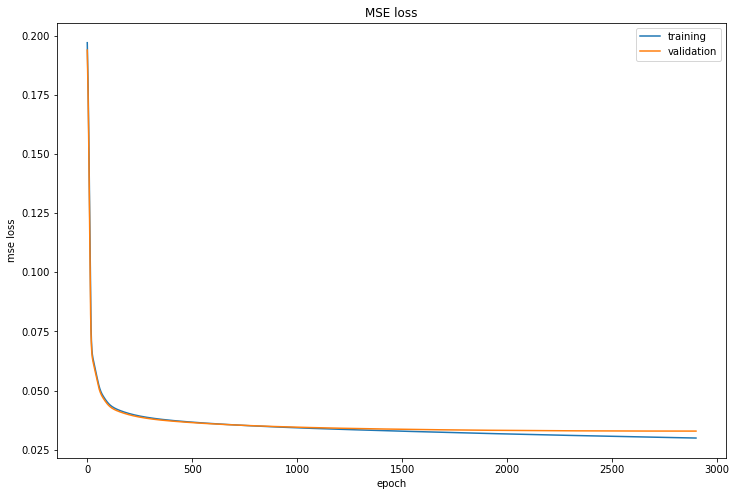

In [17]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [18]:
predictions = model.predict(test_input)

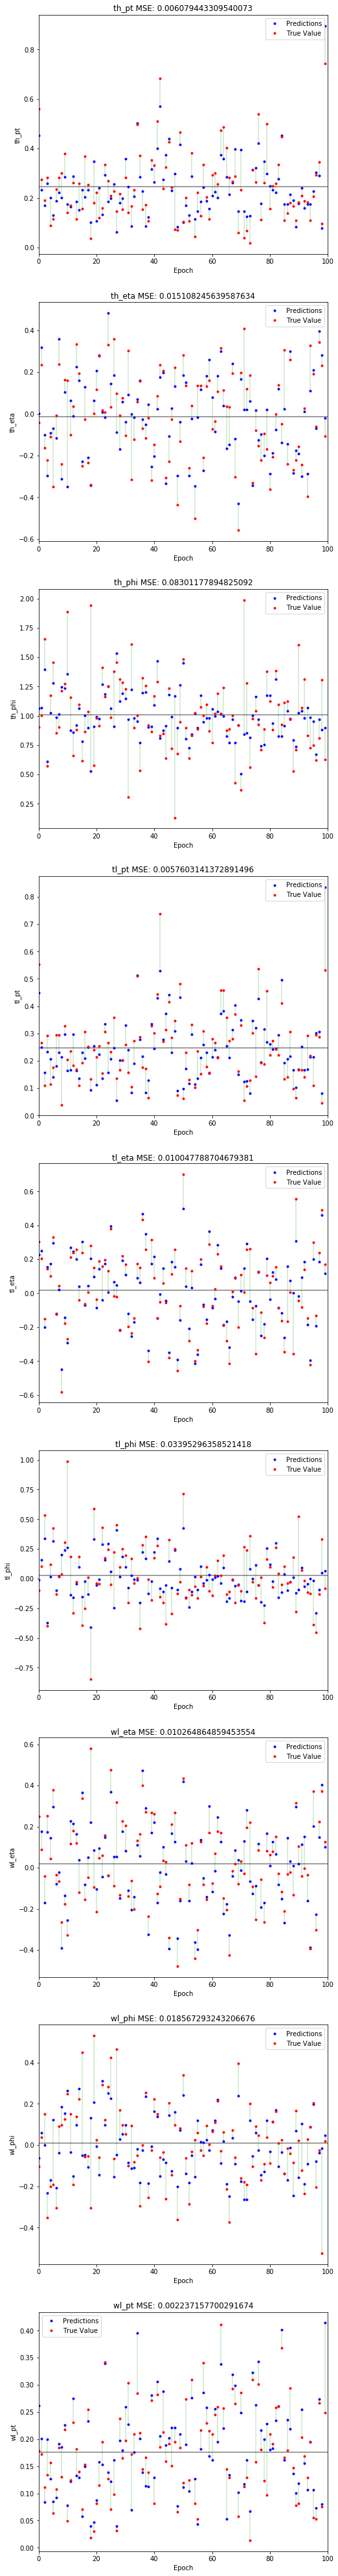

In [19]:

# Training 
crop = 100 

train_small = model.predict(train_input[0:100,:])
output_small = train_output[0:100,:]

def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*output_length))
    for i in range(0,output_length):
        plt.subplot(output_length,1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Epoch')
        plt.ylabel(output_keys[i])
        plt.xlim(0, crop)
        plt.title(output_keys[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, output_small)

In [20]:
# Predictions

predictions_small = predictions[0:100,:]
test_output_small = test_output[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- test_output)**2)
print("total MSE: " + str(MSE))

for i in range(output_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -test_output[:,i])**2)
    print("{0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

total MSE: 0.0312062565461583
th_pt MSE :  0.0062486370
th_eta MSE :  0.0192218601
th_phi MSE :  0.1192280515
tl_pt MSE :  0.0053479666
tl_eta MSE :  0.0142501899
tl_phi MSE :  0.0790320648
wl_eta MSE :  0.0092699852
wl_phi MSE :  0.0257720919
wl_pt MSE :  0.0024854620


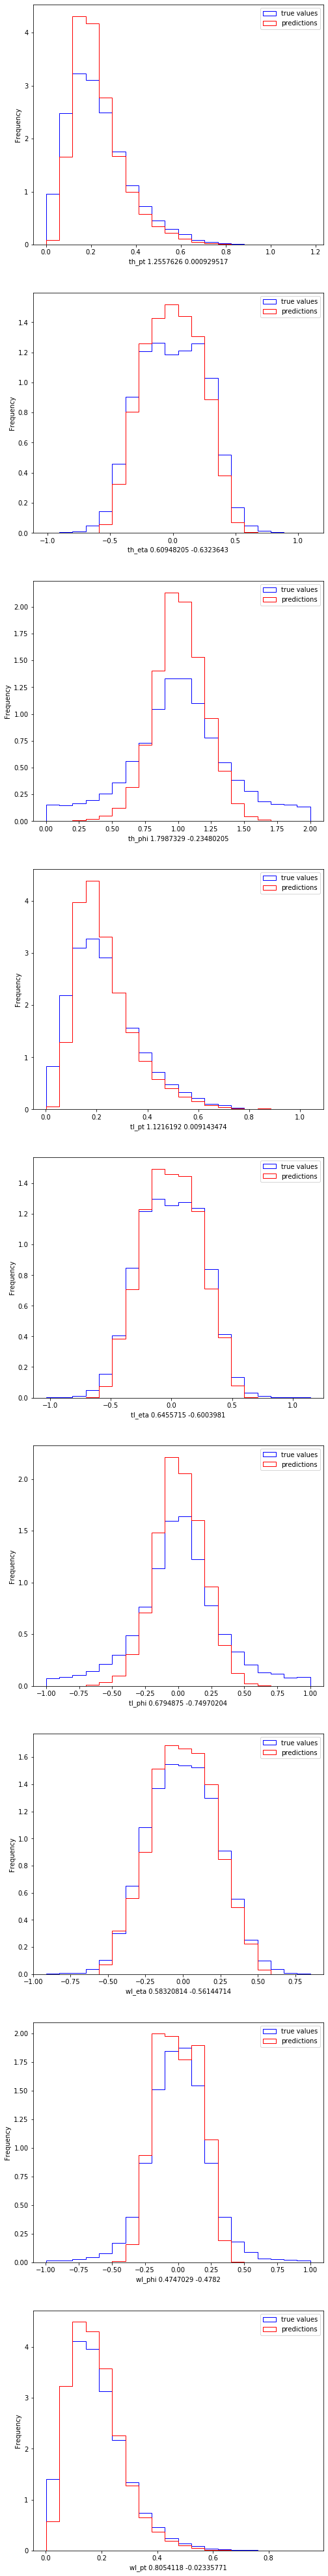

In [21]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    hist0, bin_edges = np.histogram(test_output[:, i], bins=20)
    plt.hist(test_output[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

In [22]:
total_output = scale_arrays(output_keys, maxmean)
out_scaled = invscale_arrays(output_keys, total_output, maxmean)[split:,:]

total_predictions = model.predict(total_input)
predict_scaled = invscale_arrays(output_keys, total_predictions, maxmean)[split:,:]


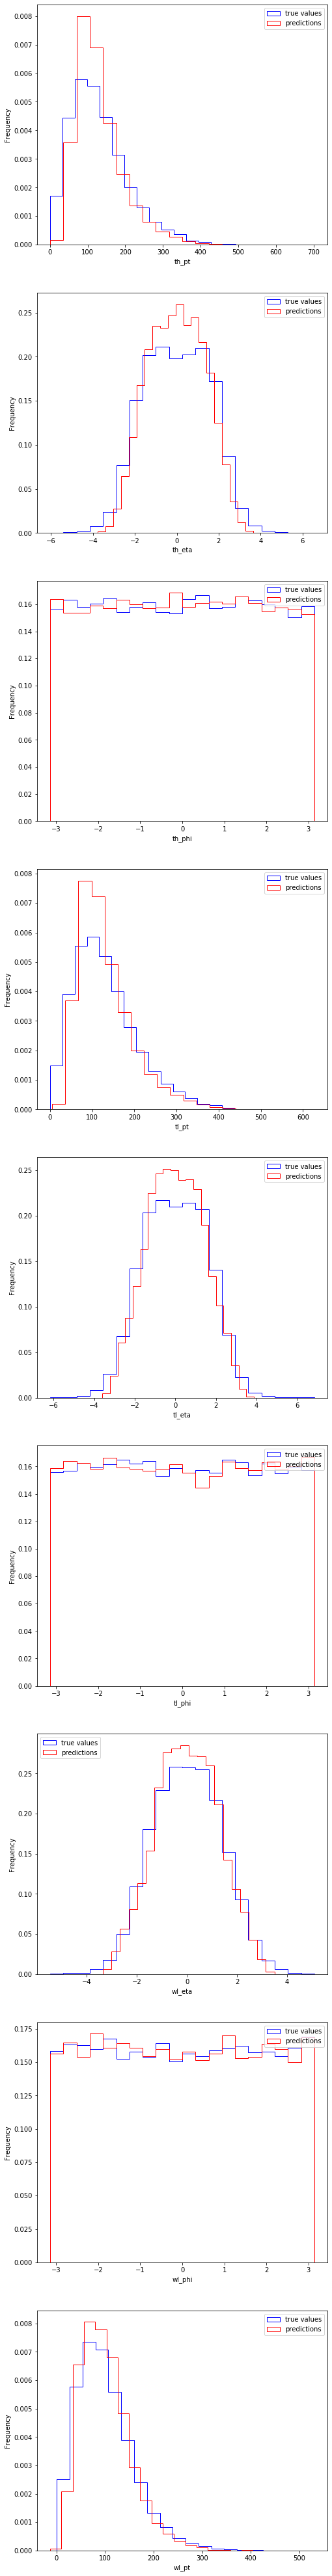

In [23]:
# Histograms to the original scale 

# out_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_output)
# out_scaled = invscale_arrays(output_keys, test_output, maxmean)
# predict_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_predictions)[split:,:]


plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.hist(out_scaled[:, i], 20, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], 20, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [24]:
for i in range(output_length):
    if output_keys[i].split("_")[1] == 'phi':
        mod_pi = (predict_scaled[:,i] - out_scaled[:,i]) % (2*np.pi)
        mod_pi = mod_pi - 2*np.pi*(mod_pi > np.pi)
        MSE = 1/predict_scaled[:,i].size*np.sum((mod_pi)**2)
    else:
        MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] - out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

Original Scale th_pt MSE :  1953.6886990124
Original Scale th_eta MSE :  0.6883714307
Original Scale th_phi MSE :  1.0704802406
Original Scale tl_pt MSE :  1672.0865356342
Original Scale tl_eta MSE :  0.5103264500
Original Scale tl_phi MSE :  0.7201976672
Original Scale wl_eta MSE :  0.3319758314
Original Scale wl_phi MSE :  0.2464888935
Original Scale wl_pt MSE :  777.1004979313


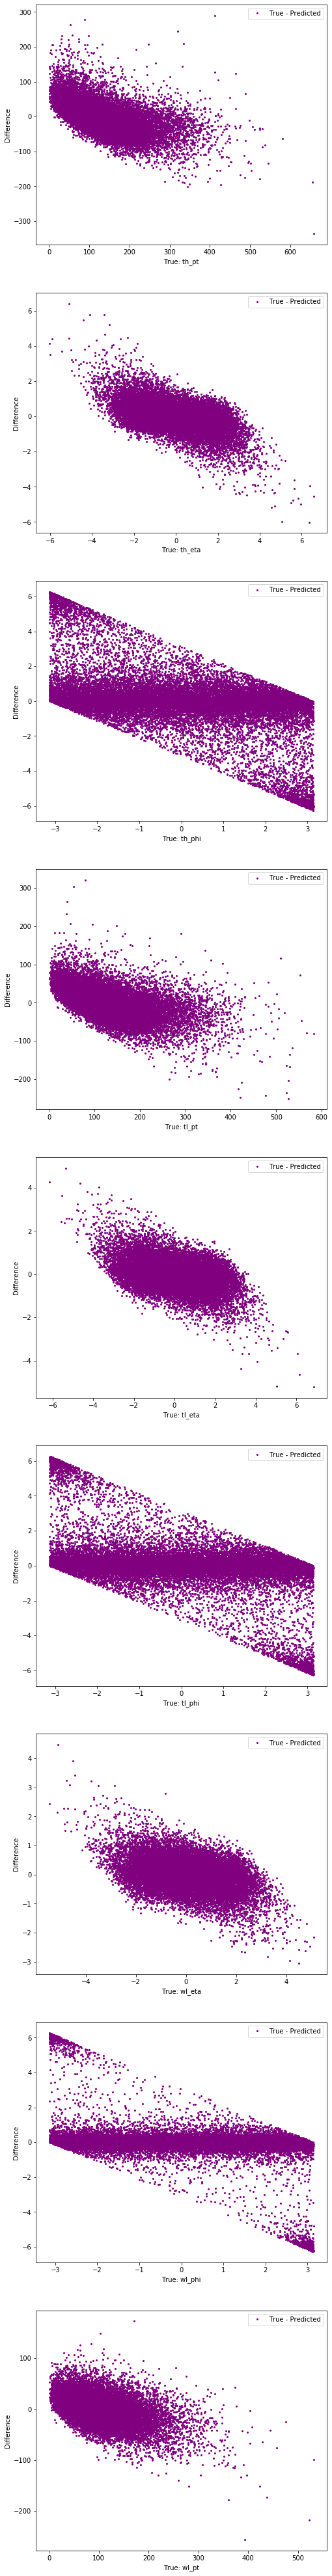

In [25]:
plt.figure(figsize=(8,8*output_length))
for i in range(output_length):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.plot(out_scaled[:, i], predict_scaled[:, i]-out_scaled[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
    plt.xlabel('True: ' + output_keys[i])
    plt.legend()
    plt.ylabel('Difference')